## Generative Adversarial Networks (GANs)

Выберите датасет, на котором хотите обучать вашу генеративную модель:
- CelebA: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
- PeopleArt: https://www.kaggle.com/datasets/amanagr/people-art-dataset
- Best Artworks of All Time: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
- Cartoon Faces (Google's Cartoon Set): https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set

Перед началом ознакомьтесь с https://github.com/soumith/ganhacks, советы оттуда можно использовать при выполнении заданий, особенно в задании 4

#### Задание 1 (2 балла). Завершите реализацию GAN

Реализуйте методы `generator_step` и `discriminator_step` в классе `GAN` с последней [практики](../workshops/12_gan.ipynb)

In [ ]:
!pip install lightning==2.4.0

In [7]:
from pathlib import Path

from typing import Callable, cast



import lightning as L

import matplotlib.pyplot as plt

import torch

import torch.nn.functional as F

import torchvision

from lightning.pytorch.loggers import TensorBoardLogger

from PIL import Image

from torch import Tensor, nn

from torch.utils.data import DataLoader, Dataset

from torchvision import transforms

In [3]:
class ImageDataset(Dataset):

    def __init__(

        self,

        datadir: Path,

        transform: Callable[[Image.Image], Tensor],

        pattern: str = "*.jpg",

    ) -> None:

        self.images = list(datadir.rglob(pattern))

        self.transform = transform



    def __getitem__(self, index) -> Tensor:

        img = Image.open(self.images[index])

        return self.transform(img)



    def __len__(self) -> int:

        return len(self.images)

In [ ]:
transform = transforms.Compose(

    [

        transforms.Resize(64),

        transforms.CenterCrop(64),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),

    ]

)

In [6]:
# если работаете локально или в Google Colab, укажите правильный путь до папки с изображениями
#../input/celeba-dataset/img_align_celeba/img_align_celeba
datadir = Path("/kaggle/input/celeba-dataset/img_align_celeba")

dataset = ImageDataset(

    datadir,

    transform=transform,

)

print(len(dataset))

print(dataset[0].shape)

202599
torch.Size([3, 64, 64])


In [8]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)



batch = next(iter(loader))

print(batch.shape)

torch.Size([16, 3, 64, 64])


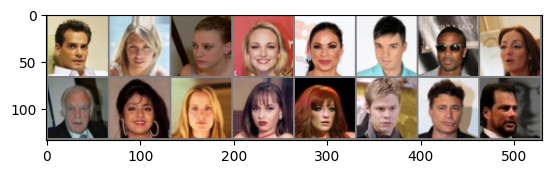

In [10]:
img_grid = torchvision.utils.make_grid(

    tensor=batch,

    nrow=8,

    padding=2,

    normalize=False,

)



plt.imshow(

    torchvision.transforms.ToPILImage()(

        img_grid * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

        + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

    )

)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
gan_loss = nn.BCEWithLogitsLoss()

In [22]:
class GAN(L.LightningModule):

    def __init__(

        self,

        generator: nn.Module,

        discriminator: nn.Module,

        discriminator_period: int = 5,
       
        epoch_size:int = 1000 #Пришлось логировать вручную

    ):

        super().__init__()

        self.discriminator = discriminator

        self.generator = generator

        self.discriminator_period = discriminator_period



        # NB: у нас 2 оптимизатора, поэтому обновлять параметры будем вручную

        self.automatic_optimization = False

        self.g_loss = 0
        self.d_loss = 0
        self.epoch_size = epoch_size-1 


    def generate(self, n: int) -> Tensor:

        # Генерируем n изображений из случайного шума

        device = next(self.generator.parameters()).device

        latent_size, *_ = next(self.generator.parameters()).data.shape

        z = torch.randn(n, latent_size, 1, 1, device=device)

        return self.generator(z)



    def training_step(self, batch: Tensor, batch_idx: int) -> None:

        # Шаг генератора

        self.g_loss = self.generator_step(batch)



        # Шаг дискриминатора

        if batch_idx % self.discriminator_period == 0:

            self.d_loss = self.discriminator_step(batch)

        if batch_idx == self.epoch_size:
            print(f"gen_loss:{self.g_loss}, disc_loss:{self.d_loss}")
        


    def configure_optimizers(self):

        # наши 2 оптимизатора: один для параметров генератора, другой — для параметров дискриминатора

        gen_opt = torch.optim.Adam(

            self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)

        )

        dis_opt = torch.optim.Adam(

            self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)

        )

        return [gen_opt, dis_opt]



    def generator_step(self, batch: Tensor):

        optimizer_g, _ = self.optimizers(use_pl_optimizer=True)



        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_g`

        self.toggle_optimizer(optimizer_g)



        # Генерируем батч изображений

        fake = self.generate(batch.size(0))

    

        # Получаем оценку дискриминатора для `fake`

        fake_scores = self.discriminator(fake)

        # Считаем ошибку генератора

        ones = torch.ones_like(fake_scores, device=device)
        
        g_loss = gan_loss(fake_scores, ones)
        

        # Обновляем параметры генератора

        self.manual_backward(g_loss)

        optimizer_g.step()

        optimizer_g.zero_grad()



        # Восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)

        self.untoggle_optimizer(optimizer_g)

    
        self.log("g_loss", g_loss, prog_bar=True)

        return g_loss

    def discriminator_step(self, batch: Tensor):

        _, optimizer_d = self.optimizers(use_pl_optimizer=True)



        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_d`

        self.toggle_optimizer(optimizer_d)

        


        # Считаем ошибку дискриминатора на реальных изображениях

        real_scores = self.discriminator(batch)
        
        ones = torch.ones_like(real_scores, device=device)
        
        real_loss = gan_loss(real_scores, ones)



        # Считаем ошибку дискриминатора на сгенерированных изображениях

        fake = self.generate(batch.size(0))

        fake_scores = self.discriminator(fake)

        zeroes = torch.zeros_like(fake_scores, device=device)
        
        fake_loss = gan_loss(fake_scores, zeroes)



        # Обновляем параметры дискриминатора

        d_loss = 0.5 * (real_loss + fake_loss)

        self.manual_backward(d_loss)

        optimizer_d.step()

        optimizer_d.zero_grad()



        # восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)

        self.untoggle_optimizer(optimizer_d)

        
        self.log("real_loss", real_loss, prog_bar=True)
        self.log("fake_loss", fake_loss, prog_bar=True)
    
        #print("D:", d_loss)
        return d_loss


    def on_train_epoch_end(self) -> None:

        images = self.generate(16)

        grid = torchvision.utils.make_grid(

            tensor=images,

            nrow=8,

            padding=2,

            normalize=True,

            value_range=(-1, 1),

        )

        str_title = f"{self.__class__.__name__}_images"

        logger = cast(TensorBoardLogger, self.logger)

        logger.experiment.add_image(str_title, grid, global_step=self.global_step)

#### Простые архитектуры генератора и дискриминатора

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

        self.conv1 = nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.conv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 2)
        self.conv4 = nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 8)
        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        x = self.conv5(x).view(-1, 1)
        return x

#### Задание 2 (4 баллов). Базовое обучение

Запустите обучение модели
- минимальное кол-во шагов: 50000 (например 50 эпох по 1000 батчей в каждой)
- минимальный размер батча: 32 (можете увеличить, если не наблюдаете при этом кратной просадки по скорости)
- в конце обучения сгенерируйте 64 изображения

In [31]:
generator = Generator(latent_size=256)

discriminator = Discriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = GAN(generator, discriminator, discriminator_period=3, epoch_size=1000)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model=lit, train_dataloaders=loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | discriminator | Discriminator | 2.8 M  | train
1 | generator     | Generator     | 4.9 M  | train
--------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.481    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

gen_loss:0.6176350116729736, disc_loss:1.2185722589492798
gen_loss:0.828698456287384, disc_loss:0.7098308801651001
gen_loss:0.8345036506652832, disc_loss:0.650532603263855
gen_loss:0.7315764427185059, disc_loss:0.7282119989395142
gen_loss:0.7836626768112183, disc_loss:0.6973111629486084
gen_loss:0.7246931195259094, disc_loss:0.7149118781089783
gen_loss:0.7349333763122559, disc_loss:0.714631199836731
gen_loss:0.7023892402648926, disc_loss:0.7065593600273132
gen_loss:0.7033167481422424, disc_loss:0.7046508193016052
gen_loss:0.7469406127929688, disc_loss:0.6915609240531921
gen_loss:0.7182396054267883, disc_loss:0.7177376747131348
gen_loss:0.7311394810676575, disc_loss:0.71262127161026
gen_loss:0.7375971674919128, disc_loss:0.6920393705368042
gen_loss:0.6106545329093933, disc_loss:0.7149525284767151
gen_loss:0.7223609685897827, disc_loss:0.6952706575393677
gen_loss:0.6411182284355164, disc_loss:0.7112029194831848
gen_loss:0.7347459197044373, disc_loss:0.6914238929748535
gen_loss:0.75900214

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


In [29]:
#!rm -rf ./logs

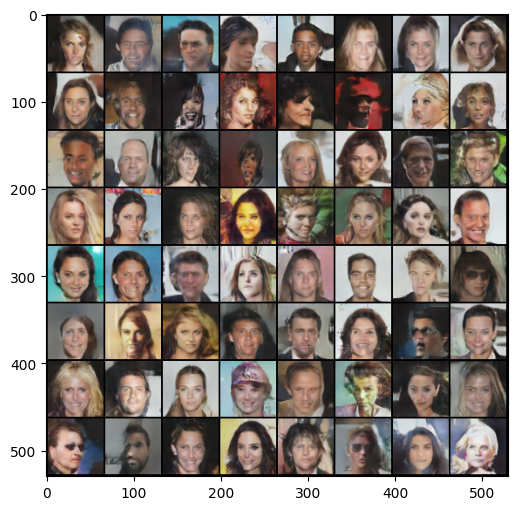

In [36]:
model_version = "version_0"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = GAN(generator, discriminator, discriminator_period=3)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

#### Задание 3 (3+5 баллов). Более стабильные версии GAN

Модифицируйте вычисление ошибки для более стабильного обучения. 
- (3 балла) LSGAN (https://paperswithcode.com/method/lsgan)
- (5 балла) Wasserstein GAN + Gradient penalty (https://paperswithcode.com/method/wgan-gp)

Запустите обучение той же длительности, что в задании 2 (>50000 шагов, батч > 32) и сгенерируйте 64 изображения. Сравните результаты с заданием 2

In [25]:
LSGAN_loss = torch.nn.MSELoss()

In [26]:
class LSGAN(L.LightningModule):

    def __init__(

        self,

        generator: nn.Module,

        discriminator: nn.Module,

        discriminator_period: int = 5,
       
        epoch_size:int = 1000 #Пришлось логировать вручную

    ):

        super().__init__()

        self.discriminator = discriminator

        self.generator = generator

        self.discriminator_period = discriminator_period



        # NB: у нас 2 оптимизатора, поэтому обновлять параметры будем вручную

        self.automatic_optimization = False

        self.g_loss = 0
        self.d_loss = 0
        self.epoch_size = epoch_size-1 


    def generate(self, n: int) -> Tensor:

        # Генерируем n изображений из случайного шума

        device = next(self.generator.parameters()).device

        latent_size, *_ = next(self.generator.parameters()).data.shape

        z = torch.randn(n, latent_size, 1, 1, device=device)

        return self.generator(z)



    def training_step(self, batch: Tensor, batch_idx: int) -> None:

        # Шаг генератора

        self.g_loss = self.generator_step(batch)



        # Шаг дискриминатора

        if batch_idx % self.discriminator_period == 0:

            self.d_loss = self.discriminator_step(batch)

        if batch_idx == self.epoch_size:
            print(f"gen_loss:{self.g_loss}, disc_loss:{self.d_loss}")
        


    def configure_optimizers(self):

        # наши 2 оптимизатора: один для параметров генератора, другой — для параметров дискриминатора

        gen_opt = torch.optim.Adam(

            self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)

        )

        dis_opt = torch.optim.Adam(

            self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)

        )

        return [gen_opt, dis_opt]



    def generator_step(self, batch: Tensor):

        optimizer_g, _ = self.optimizers(use_pl_optimizer=True)



        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_g`

        self.toggle_optimizer(optimizer_g)



        # Генерируем батч изображений

        fake = self.generate(batch.size(0))

    

        # Получаем оценку дискриминатора для `fake`

        fake_scores = self.discriminator(fake)

        # Считаем ошибку генератора

        ones = torch.ones_like(fake_scores, device=device)
        
        g_loss = LSGAN_loss(fake_scores, ones)
        

        # Обновляем параметры генератора

        self.manual_backward(g_loss)

        optimizer_g.step()

        optimizer_g.zero_grad()



        # Восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)

        self.untoggle_optimizer(optimizer_g)

    
        self.log("g_loss", g_loss, prog_bar=True)

        return g_loss

    def discriminator_step(self, batch: Tensor):

        _, optimizer_d = self.optimizers(use_pl_optimizer=True)



        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_d`

        self.toggle_optimizer(optimizer_d)

        


        # Считаем ошибку дискриминатора на реальных изображениях

        real_scores = self.discriminator(batch)
        
        ones = torch.ones_like(real_scores, device=device)
        
        real_loss = LSGAN_loss(real_scores, ones)



        # Считаем ошибку дискриминатора на сгенерированных изображениях

        fake = self.generate(batch.size(0))

        fake_scores = self.discriminator(fake)

        zeroes = torch.zeros_like(fake_scores, device=device)
        
        fake_loss = LSGAN_loss(fake_scores, zeroes)



        # Обновляем параметры дискриминатора

        d_loss = 0.5 * (real_loss + fake_loss)

        self.manual_backward(d_loss)

        optimizer_d.step()

        optimizer_d.zero_grad()



        # восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)

        self.untoggle_optimizer(optimizer_d)

        
        self.log("real_loss", real_loss, prog_bar=True)
        self.log("fake_loss", fake_loss, prog_bar=True)
    
        #print("D:", d_loss)
        return d_loss


    def on_train_epoch_end(self) -> None:

        images = self.generate(16)

        grid = torchvision.utils.make_grid(

            tensor=images,

            nrow=8,

            padding=2,

            normalize=True,

            value_range=(-1, 1),

        )

        str_title = f"{self.__class__.__name__}_images"

        logger = cast(TensorBoardLogger, self.logger)

        logger.experiment.add_image(str_title, grid, global_step=self.global_step)

In [45]:
generator = Generator(latent_size=256)

discriminator = Discriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = LSGAN(generator, discriminator, discriminator_period=3, epoch_size=1000)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

trainer.fit(model=lit, train_dataloaders=loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | discriminator | Discriminator | 2.8 M  | train
1 | generator     | Generator     | 4.9 M  | train
--------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.481    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

gen_loss:0.6080276966094971, disc_loss:0.06995480507612228
gen_loss:1.220184326171875, disc_loss:0.010329370386898518
gen_loss:0.27188292145729065, disc_loss:0.2859290838241577
gen_loss:0.2885792851448059, disc_loss:0.2870233952999115
gen_loss:0.2883390486240387, disc_loss:0.26246142387390137
gen_loss:0.27434730529785156, disc_loss:0.27517634630203247
gen_loss:0.2714490592479706, disc_loss:0.2620355486869812
gen_loss:0.28122419118881226, disc_loss:0.2648640275001526
gen_loss:0.2549833059310913, disc_loss:0.28701308369636536
gen_loss:0.4373098313808441, disc_loss:0.28856557607650757
gen_loss:0.28916507959365845, disc_loss:0.24758489429950714
gen_loss:0.31847965717315674, disc_loss:0.28261253237724304
gen_loss:0.3246617913246155, disc_loss:0.272067129611969
gen_loss:0.40250688791275024, disc_loss:0.2795976996421814
gen_loss:0.29455870389938354, disc_loss:0.2543356418609619
gen_loss:0.27437084913253784, disc_loss:0.2596670389175415
gen_loss:0.2485208362340927, disc_loss:0.2516888082027435

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


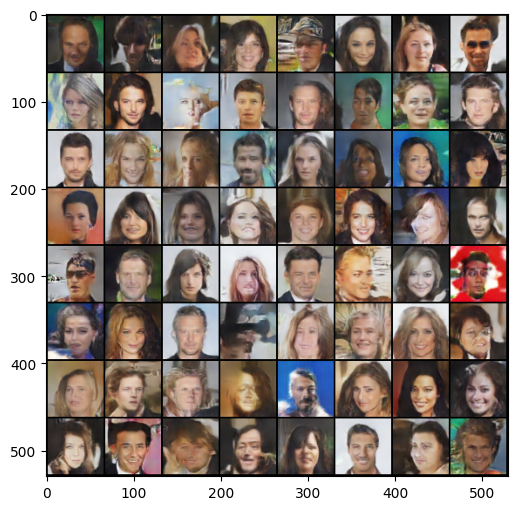

In [46]:
model_version = "version_1"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = GAN(generator, discriminator, discriminator_period=3)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

In [15]:
import torch.autograd as autograd

In [13]:
class WassersteinGAN(L.LightningModule):

    def __init__(

        self,

        generator: nn.Module,

        discriminator: nn.Module,

        generator_period: int = 5,
       
        epoch_size:int = 1000, #Пришлось логировать вручную

        lambda_gp:int = 10,

        opt_g_step:float = 0.001,
        opt_d_step:float = 0.001,
        betas: list = (0, 0.999),

    ):

        super().__init__()

        self.discriminator = discriminator

        self.generator = generator

        self.generator_period = generator_period

        self.lambda_gp = lambda_gp

        self.opt_g_step = opt_g_step
        self.opt_d_step = opt_d_step
        self.betas = betas


        # NB: у нас 2 оптимизатора, поэтому обновлять параметры будем вручную

        self.automatic_optimization = False

        self.g_loss = 0
        self.d_loss = 0
        self.epoch_size = epoch_size-1 


    def generate(self, n: int) -> Tensor:

        # Генерируем n изображений из случайного шума

        device = next(self.generator.parameters()).device

        latent_size, *_ = next(self.generator.parameters()).data.shape

        z = torch.randn(n, latent_size, 1, 1, device=device)

        return self.generator(z)



    def training_step(self, batch: Tensor, batch_idx: int) -> None:

        # Шаг генератора

        self.d_loss = self.discriminator_step(batch)



        # Шаг дискриминатора

        if batch_idx % self.generator_period == 0:

            self.g_loss = self.generator_step(batch)

        if batch_idx == self.epoch_size:
            print(f"gen_loss:{self.g_loss}, disc_loss:{self.d_loss}")
        


    def configure_optimizers(self):

        # наши 2 оптимизатора: один для параметров генератора, другой — для параметров дискриминатора

        gen_opt = torch.optim.Adam(

            self.generator.parameters(), lr=self.opt_g_step, betas=self.betas

        )

        dis_opt = torch.optim.Adam(

            self.discriminator.parameters(), lr=self.opt_d_step, betas=self.betas

        )

        return [gen_opt, dis_opt]



    def generator_step(self, batch: Tensor):

        optimizer_g, _ = self.optimizers(use_pl_optimizer=True)



        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_g`

        self.toggle_optimizer(optimizer_g)



        # Генерируем батч изображений

        fake = self.generate(batch.size(0))

    

        # Получаем оценку дискриминатора для `fake`

        fake_scores = self.discriminator(fake)

        # Считаем ошибку генератора

        
        g_loss = -torch.mean(fake_scores)
        

        # Обновляем параметры генератора

        self.manual_backward(g_loss)

        optimizer_g.step()

        optimizer_g.zero_grad()



        # Восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)

        self.untoggle_optimizer(optimizer_g)


        return g_loss

    def discriminator_step(self, batch: Tensor):

        _, optimizer_d = self.optimizers(use_pl_optimizer=True)



        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_d`

        self.toggle_optimizer(optimizer_d)

        


        # Считаем ошибку дискриминатора на реальных изображениях

        real_scores = self.discriminator(batch)
        


        # Считаем ошибку дискриминатора на сгенерированных изображениях

        fake = self.generate(batch.size(0))

        fake_scores = self.discriminator(fake)


        alpha = torch.rand(batch.size(0),1,1,1, device=device)

        interpolates = (alpha * batch + (torch.tensor(1,device=device)-alpha) * fake).requires_grad_(True)

        d_interpolates = self.discriminator(interpolates)

        grad_outputs= torch.ones_like(d_interpolates, device=device)

        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()


        

        # Обновляем параметры дискриминатора

        d_loss = -torch.mean(real_scores) + torch.mean(fake_scores) + self.lambda_gp * gradient_penalty

        self.manual_backward(d_loss)

        optimizer_d.step()

        optimizer_d.zero_grad()



        # восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)

        self.untoggle_optimizer(optimizer_d)


        return d_loss


    def on_train_epoch_end(self) -> None:

        images = self.generate(16)

        grid = torchvision.utils.make_grid(

            tensor=images,

            nrow=8,

            padding=2,

            normalize=True,

            value_range=(-1, 1),

        )

        str_title = f"{self.__class__.__name__}_images"

        logger = cast(TensorBoardLogger, self.logger)

        logger.experiment.add_image(str_title, grid, global_step=self.global_step)

In [44]:
generator = Generator(latent_size=256)

discriminator = Discriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = WassersteinGAN(generator, discriminator, generator_period=3, epoch_size=1000)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

trainer.fit(model=lit, train_dataloaders=loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | discriminator | Discriminator | 2.8 M  | train
1 | generator     | Generator     | 4.9 M  | train
--------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.481    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

gen_loss:24.485004425048828, disc_loss:-10.6458101272583
gen_loss:22.937206268310547, disc_loss:-10.13443374633789
gen_loss:27.241226196289062, disc_loss:-7.700582981109619
gen_loss:19.85686683654785, disc_loss:-6.3912739753723145
gen_loss:33.095096588134766, disc_loss:-8.025500297546387
gen_loss:29.94007110595703, disc_loss:-7.695010185241699
gen_loss:34.76079559326172, disc_loss:-7.087810516357422
gen_loss:32.58711242675781, disc_loss:-7.533487319946289
gen_loss:33.40467834472656, disc_loss:-1.9246805906295776
gen_loss:38.255149841308594, disc_loss:-0.29215627908706665
gen_loss:38.20396423339844, disc_loss:-6.350962162017822
gen_loss:31.522480010986328, disc_loss:-6.8164262771606445
gen_loss:31.288938522338867, disc_loss:-1.6356189250946045
gen_loss:36.834651947021484, disc_loss:-2.966965913772583
gen_loss:37.96015167236328, disc_loss:-3.918222188949585
gen_loss:37.484561920166016, disc_loss:-9.100040435791016
gen_loss:34.54383850097656, disc_loss:-8.595187187194824
gen_loss:28.79772

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


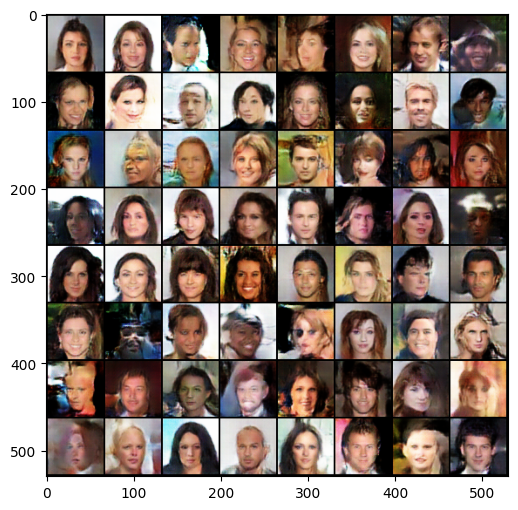

In [52]:
model_version = "version_2"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = GAN(generator, discriminator, discriminator_period=3)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

#### Задание 4 (6 баллов). Донастройка

Выберите любой вариант GAN (vanilla GAN, LSGAN, Wasserstein GAN), но перед запуском длительного обучения поэкспериментируйте с настройками обучения, чтобы найти лучшую конфигурацию.

Для этого запустите не менее 3 предварительных сессий обучения на >30000 шагов и сгенерируйте примеры для всех запусков.

Главные настройки:
- learning rate оптимизаторов
- относительная частота обновления весов генератора и дискриминатора (можете изменить реализацию `training_step`, если хотите)
- архитектуры моделей: например, можете увеличить размеры моделей или докинуть слоёв

По результатам коротких запусков выберите удачную конфигурацию и запустите обучение на >100000 шагов, выведите примеры генерации в конце обучения

In [11]:
class ResGenerator(nn.Module):

    def __init__(self, latent_size: int):

        super().__init__()

        self.latent_size = latent_size
        self.conv1 = nn.ConvTranspose2d(latent_size, 128 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(128 * 8)
        self.conv2 = nn.ConvTranspose2d(128 * 8, 128 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128 * 4)
        self.conv3 = nn.ConvTranspose2d(128 * 4, 128 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128 * 2)
        self.conv4 = nn.ConvTranspose2d(128 * 2, 128, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False)



    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))





class ResDiscriminator(nn.Module):

    def __init__(self):

        super().__init__()


        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(128, 128 * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128 * 2)
        self.conv3 = nn.Conv2d(128 * 2, 128 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128 * 4)
        self.conv4 = nn.Conv2d(128 * 4, 128 * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128 * 8)
        self.conv5 = nn.Conv2d(128 * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)  
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)  
        x = self.conv5(x).view(-1, 1)
        return x

In [17]:
generator = Generator(latent_size=256)

discriminator = Discriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=15,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = WassersteinGAN(generator, discriminator, generator_period=5, epoch_size=1000,
betas = (0.3, 0.999), opt_d_step = 0.003, opt_g_step = 0.003                                          
)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

trainer.fit(model=lit, train_dataloaders=loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | discriminator | Discriminator | 2.8 M  | train
1 | generator     | Generator     | 4.9 M  | train
--------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.481    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

gen_loss:-79.52468872070312, disc_loss:-4.552028179168701
gen_loss:-74.66883850097656, disc_loss:-4.748327732086182
gen_loss:-85.58042907714844, disc_loss:-4.565523147583008
gen_loss:-93.08213806152344, disc_loss:-6.77007532119751
gen_loss:-100.13424682617188, disc_loss:-4.863269805908203
gen_loss:-110.24822998046875, disc_loss:-4.980669975280762
gen_loss:-117.05264282226562, disc_loss:-3.991286277770996
gen_loss:-128.1961669921875, disc_loss:-4.638556957244873
gen_loss:-150.3126220703125, disc_loss:-5.4311652183532715
gen_loss:-146.1032257080078, disc_loss:-3.0436248779296875
gen_loss:-167.31124877929688, disc_loss:-2.3483505249023438
gen_loss:-176.25592041015625, disc_loss:-2.588566780090332
gen_loss:-185.09912109375, disc_loss:-4.941737651824951
gen_loss:-179.2683563232422, disc_loss:-3.46248722076416
gen_loss:-187.13153076171875, disc_loss:-4.495992660522461


INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


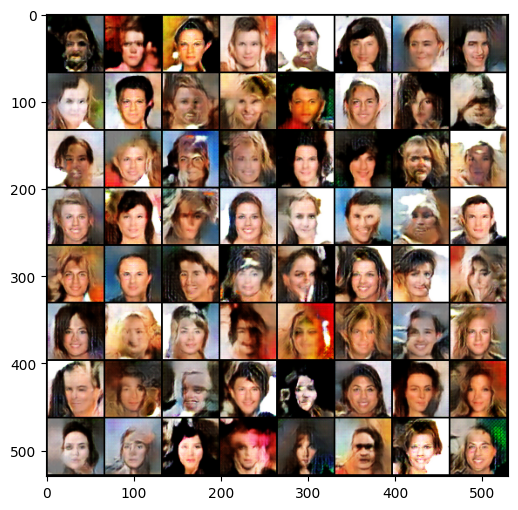

In [44]:
model_version = "version_3"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = WassersteinGAN(generator, discriminator, generator_period=5)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

In [ ]:
generator = ResGenerator(latent_size=256)

discriminator = ResDiscriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=30,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = WassersteinGAN(generator, discriminator, generator_period=3, epoch_size=1000,
betas = (0.3, 0.999), opt_d_step = 0.001, opt_g_step = 0.001                                         
)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

trainer.fit(model=lit, train_dataloaders=loader)

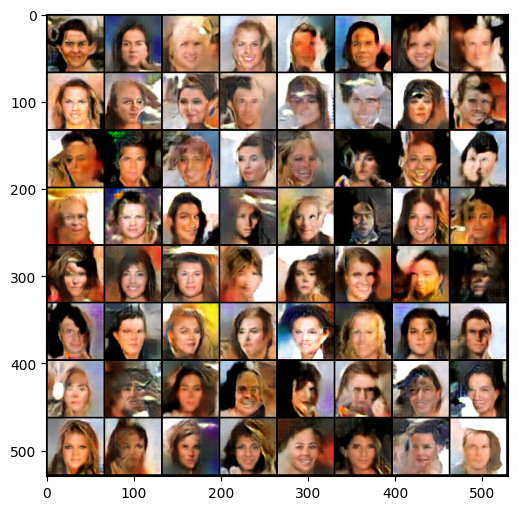

In [54]:
model_version = "version_4"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = WassersteinGAN(generator, discriminator)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

In [ ]:
generator = ResGenerator(latent_size=256)

discriminator = ResDiscriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=30,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = WassersteinGAN(generator, discriminator, generator_period=4, epoch_size=1000,
betas = (0.3, 0.999), opt_d_step = 0.002, opt_g_step = 0.005                                          
)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

trainer.fit(model=lit, train_dataloaders=loader)

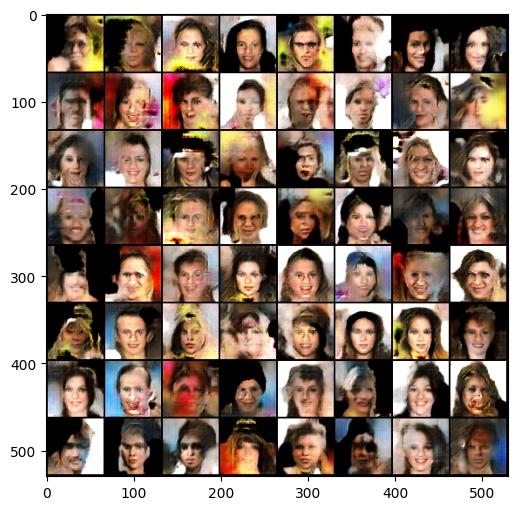

In [52]:
model_version = "version_5"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = WassersteinGAN(generator, discriminator)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

In [69]:
generator = ResGenerator(latent_size=256)

discriminator = ResDiscriminator()



trainer = L.Trainer(
    accelerator="auto",
    max_epochs=100,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,    
)



lit = WassersteinGAN(generator, discriminator, generator_period=3, epoch_size=1000,
betas = (0.3, 0.999), opt_d_step = 0.001, opt_g_step = 0.001                                         
)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=3)

trainer.fit(model=lit, train_dataloaders=loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | discriminator | ResDiscriminator | 11.0 M | train
1 | generator     | ResGenerator     | 15.2 M | train
-----------------------------------------------------------
26.3 M    Trainable params
0         Non-trainable params
26.3 M    Total params
105.002   Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

gen_loss:6.249617576599121, disc_loss:-12.551641464233398
gen_loss:-5.942039489746094, disc_loss:-12.819129943847656
gen_loss:-8.29318904876709, disc_loss:-6.751772403717041
gen_loss:-14.778419494628906, disc_loss:-8.810084342956543
gen_loss:-1.0070981979370117, disc_loss:-5.515067100524902
gen_loss:4.444015979766846, disc_loss:-5.963245868682861
gen_loss:12.947460174560547, disc_loss:-4.250896453857422
gen_loss:12.576164245605469, disc_loss:-1.546912670135498
gen_loss:-0.35131287574768066, disc_loss:-5.6205315589904785
gen_loss:7.38139533996582, disc_loss:-0.5220959186553955
gen_loss:14.97155475616455, disc_loss:-0.8277930617332458
gen_loss:11.521049499511719, disc_loss:-2.6025304794311523
gen_loss:21.516420364379883, disc_loss:-0.22810742259025574
gen_loss:11.262394905090332, disc_loss:-0.24248343706130981
gen_loss:14.671290397644043, disc_loss:-2.7667369842529297
gen_loss:10.826432228088379, disc_loss:-5.815512180328369
gen_loss:14.805158615112305, disc_loss:-4.791723251342773
gen_l

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


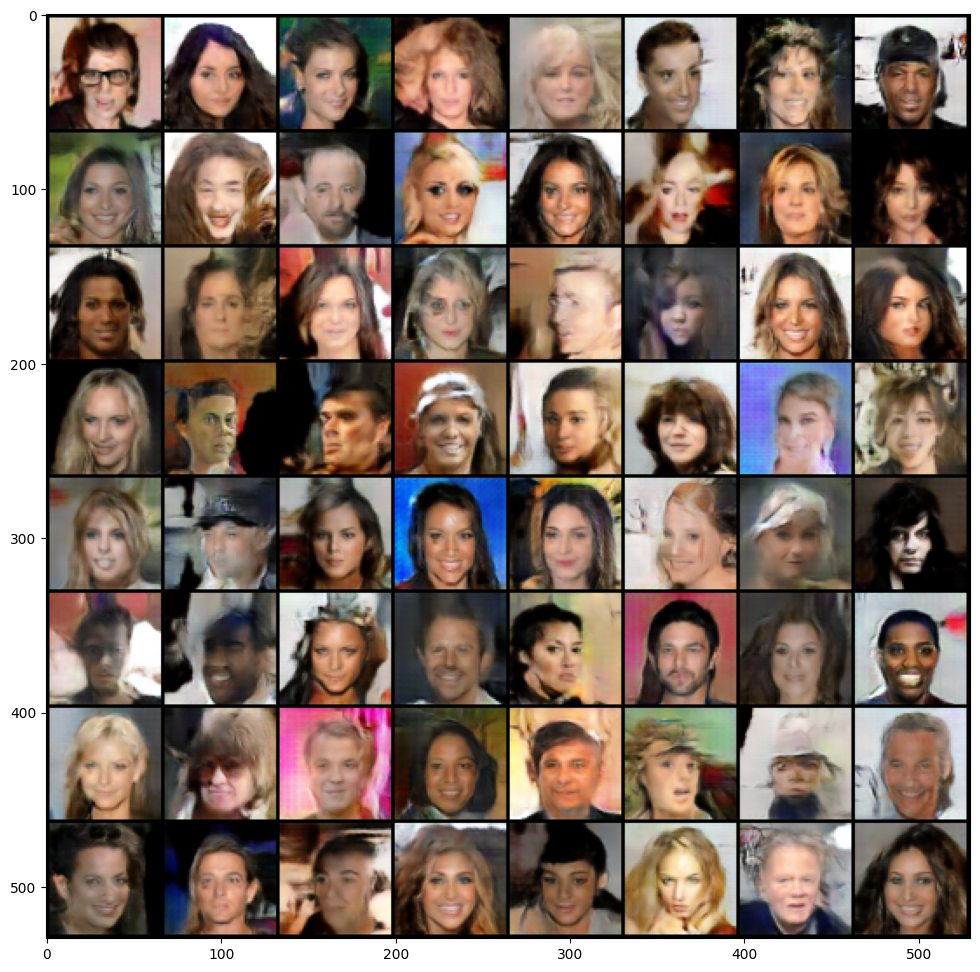

In [88]:
model_version = "version_6"

checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))

lit = WassersteinGAN(generator, discriminator)

lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])

images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

Увеличил hiden_size генератора и дискриминатора.

генератор:   latent_size->1024->512->256->128->3
        
дискриминатор:   3->128->256->512->1024

Количество параметров с 7.6 M увелисчилось до 26.3 M

В WassersteinGAN дискримиантор учится чаще, generator_period=3(в статье generator_period=5) 

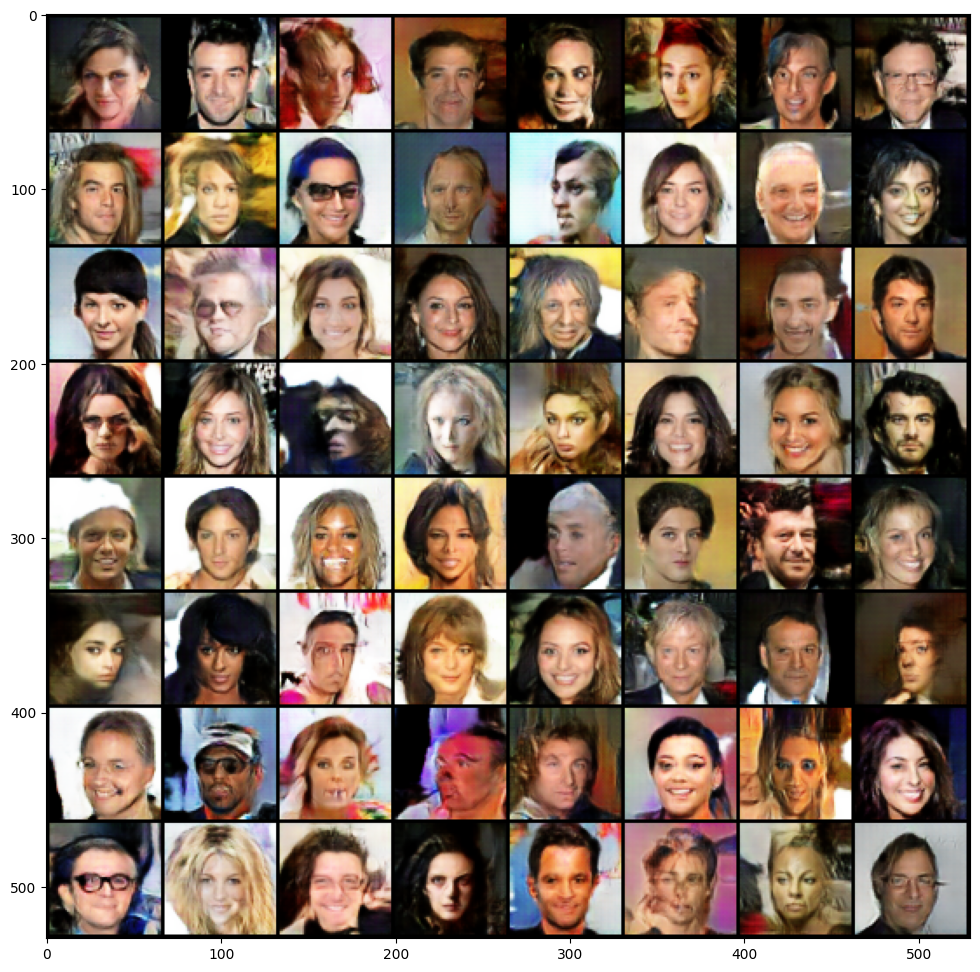

In [90]:
images = lit.generate(n=64)

grid = torchvision.utils.make_grid(

    tensor=images,

    nrow=8,

    padding=2,

    normalize=True,

    value_range=(-1, 1),

)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(torchvision.transforms.ToPILImage()(grid))

Увеличил hiden_size генератора и дискриминатора.

генератор:   latent_size->1024->512->256->128->3
        
дискриминатор:   3->128->256->512->1024

Количество параметров с 7.6 M увелисчилось до 26.3 M

В WassersteinGAN дискримиантор учится чаще, generator_period=3(в статье generator_period=5) 

После 100 эпох на лица можно даже смотреть